# Home Loan Approval Predictions Analysis & Model Development.

## 1. Problem Statement

A loan is a sum of money that one or more individuals or companies borrow from banks or other financial institutions; to financially manage events. In doing so, the borrower incurs a debt, which he has to pay back with interest within a given period.
Loans can be education loans or personal loans. The most common type of loan is a **Home Loan** or **Mortgage**. A mortgage is a type of secured loan which is taken for the purchase of a property. A typical process for home loans starts with an application from the customer; after that company will validate the eligibility of the customer for a loan, based on the result application can be accepted or rejected.. The loan approval  is the most crucial stage of a home loan process and takes a long time to complete. 

We can automate this process of eligibility of customers for a home loan using a Machine Learning algorithm. Our objective is to build a machine learning model to predict whether a particular customer is eligible for a home loan based on the customer details provided while filling out the online application form.

### The dataset

The dataset is taken from the analytics vidya hackathon platform. You can download the data from [here](https://datahack.analyticsvidhya.com/contest/practice-problem-loan-prediction-iii/#ProblemStatement). There are three data files available to download while I have used only the `train.csv` file to train and validate a machine learning model.

The description of data attributes is as follows:

|Attributes|Description|
|-|-|
|loan id | Applicant's unqiue loan id|
|gender|  Applicant's gender male/female|
|married | Whether applicant is married or not (Y/N)|
|dependents | Number of dependents on applicant|
|education |  Education level of applicant(graduate/under graduate)|
|self-employed | self employed (y/n)|
|applicant-income | Applicant income|
|co-applicant income | Coapplicant's income, who is apply with applicant as money borrowers.|
|loan amount | Loan amount in thousands|
|loan amount term | Amount of time the lender gives you to repay your laon.|
|credit history | Credit history meets guidlines|
|property area | urban/semi urban / rural|
|loan status | loan approved(y/n)|

This is binary classification machine learning problem, where we will predict the `loan_status` which describes `1` if application is approved and `0` if application is rejected.

## 2. Data Preparation

In [71]:
# importing libraries
import pandas as pd
import numpy as np 

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from scipy import stats

# Data Preprocessing
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# cross validation
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.model_selection import cross_val_score

# classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC

from sklearn.metrics import f1_score

# Setting color palatte
colors = ['#007bff','#fcb107','#28a745','#dc3545']
sns.set_theme('talk')
sns.set_palette(colors)

plt.rcParams['figure.dpi'] = 70
plt.rcParams['figure.figsize'] = [8, 5]

In [3]:
# reading data 
df = pd.read_csv("data.csv")

# view first five rows
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [4]:
# shape of the data
print("Number of instances  ::", df.shape[0])
print("Number of attributes ::", df.shape[1])

Number of instances  :: 614
Number of attributes :: 13


In [5]:
# Columns names.
column_list = df.columns.tolist()
print("List of columns:: ", column_list)

List of columns::  ['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status']


In [6]:
# Clean up the column names.
rename_col = {
    'ApplicantIncome':'applicant_income',
    'CoapplicantIncome':'coapplicant_income',
    'LoanAmount':'loan_amount'
}

df.rename(columns=rename_col, inplace=True)
df.rename(columns={col:col.lower() for col in column_list}, inplace=True)        

In [7]:
# view
df.head()

,loan_id,gender,married,dependents,education,self_employed,applicant_income,coapplicant_income,loan_amount,loan_amount_term,credit_history,property_area,loan_status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [8]:
# Check if there is any duplicate records present in the data
df.duplicated().sum()

0

In [9]:
# Check the datatypes.
df.dtypes

loan_id                object
gender                 object
married                object
dependents             object
education              object
self_employed          object
applicant_income        int64
coapplicant_income    float64
loan_amount           float64
loan_amount_term      float64
credit_history        float64
property_area          object
loan_status            object
dtype: object

In [10]:
# Check the unique values in categorical data.
columns = ['gender', 
            'married', 
            'dependents', 
            'education', 
            'self_employed', 
            'credit_history', 
            'property_area', 
            'loan_status'
        ]

for col in columns:
    print(f"{col.upper()} :: {df[col].unique()}")
    print(df[col].value_counts())
    print("---"*10)

GENDER :: ['Male' 'Female' nan]
Male      489
Female    112
Name: gender, dtype: int64
------------------------------
MARRIED :: ['No' 'Yes' nan]
Yes    398
No     213
Name: married, dtype: int64
------------------------------
DEPENDENTS :: ['0' '1' '2' '3+' nan]
0     345
1     102
2     101
3+     51
Name: dependents, dtype: int64
------------------------------
EDUCATION :: ['Graduate' 'Not Graduate']
Graduate        480
Not Graduate    134
Name: education, dtype: int64
------------------------------
SELF_EMPLOYED :: ['No' 'Yes' nan]
No     500
Yes     82
Name: self_employed, dtype: int64
------------------------------
CREDIT_HISTORY :: [ 1.  0. nan]
1.0    475
0.0     89
Name: credit_history, dtype: int64
------------------------------
PROPERTY_AREA :: ['Urban' 'Rural' 'Semiurban']
Semiurban    233
Urban        202
Rural        179
Name: property_area, dtype: int64
------------------------------
LOAN_STATUS :: ['Y' 'N']
Y    422
N    192
Name: loan_status, dtype: int64
-------------

### 2.1 Typecasting

In [11]:
"""
Let's change the case of string values in categorical columns in lower case and replace space if any with underscore(_).
& change the data type of those columns from `object` to `category`. 
"""
categorical_cols = ['gender', 
            'married', 
            'dependents', 
            'education', 
            'self_employed', 
            'property_area', 
            'loan_status'
        ]
for col in categorical_cols:
    try:
        df[col] = df[col].str.lower().str.replace(" ", "_")
        df[col] = df[col].astype('category')                
    except AttributeError:
        pass

In [12]:
# view
df.dtypes

loan_id                 object
gender                category
married               category
dependents            category
education             category
self_employed         category
applicant_income         int64
coapplicant_income     float64
loan_amount            float64
loan_amount_term       float64
credit_history         float64
property_area         category
loan_status           category
dtype: object

### 2.2 Missing data

In [13]:
# Let's check for missing data.
df.isnull().sum()

loan_id                0
gender                13
married                3
dependents            15
education              0
self_employed         32
applicant_income       0
coapplicant_income     0
loan_amount           22
loan_amount_term      14
credit_history        50
property_area          0
loan_status            0
dtype: int64

There are some missing values presents in data.

### 2.3 Correlation Data  Analysis ( Categorical Variables )

#### 2.3.1 Response Variable   -  Loan Status

In [14]:
df.loan_status.value_counts(normalize=True)

y    0.687296
n    0.312704
Name: loan_status, dtype: float64

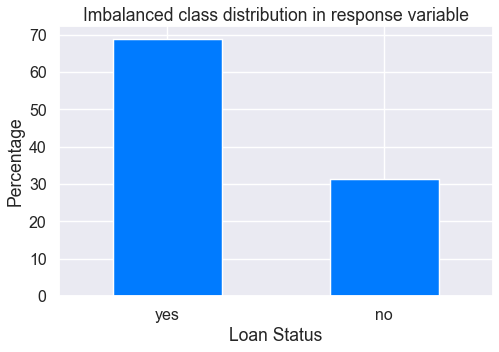

In [15]:
# Response variable - loan_status
# visualization
(df.loan_status.value_counts(normalize=True) * 100).plot(kind='bar')

# labels
plt.xlabel("Loan Status")
plt.ylabel("Percentage")
plt.title("Imbalanced class distribution in response variable")

plt.xticks(ticks=[0, 1], labels=['yes', 'no'], rotation=0)
plt.show()

We can see from the above bar plot that, the distribution of classes in response variable `loan_status` is highly imbalanced as the number of instances for `y` is more than of that `n`.

In [16]:
# Hypothesis testing for correlation in variables.
def compute_chi2(column):
    """
    compute_chi2(column):
        function to compute the correlation between the categorical variable and response variale(y).
    """
    threshold = 0.05
    ct = pd.crosstab(df[column], df['loan_status'])    
    result = stats.chi2_contingency(ct)
    
    print("Chi2-statistics:: ", result[0])
    print("p-value:: ", result[1])
    
    if result[1] < threshold:
        print("p-value is less than 0.05, the null hypothesis is rejected hence, %s & loan_status are dependent variables." %column)   
    else:
        print("p-value is greater than 0.05, which failed to reject the null hypothesis hence, %s & loan_status are Independent variables." %column)    

#### 2.3.2 Correlation - Gender & Loan Status

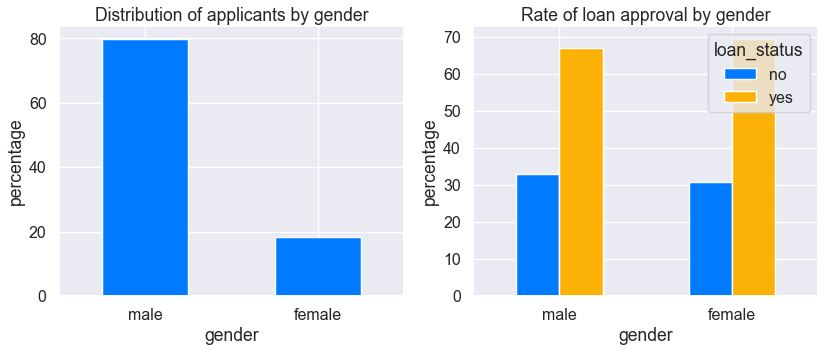

In [17]:
# Gender 
"""Let's find if the `gender` of the applicant is matter in loan approval."""
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

# Data preparation
a = df['gender'].value_counts() * 100 / len(df)  
b = df.groupby(by=['gender', 'loan_status']).count()['loan_id'] * 100 / df.groupby(by=['gender']).count()['loan_id']

# Visualizations
# plot-1
a.plot(kind='bar', ax=ax1) 

ax1.set_title("Distribution of applicants by gender")
ax1.set_xlabel("gender")
ax1.set_ylabel("percentage")

ax1.set_xticks(ticks=[0, 1], labels=['male', 'female'], rotation=0)

# plot-2
b.unstack().plot(kind='bar', ax=ax2)

ax2.set_title("Rate of loan approval by gender")
ax2.set_xlabel("gender")
ax2.set_ylabel("percentage")

ax2.legend(labels=['no', 'yes'], title='loan_status')
ax2.set_xticks(ticks=[0, 1], labels=['male', 'female'], rotation=0)

plt.show()

Above plot shows that, There is huge difference between the male and female applicant for loan. However, the second plot shows that, rate of accepting or rejecting the loan application for home is almost same for both male and female applicant, hence we can say that, the approval of loan does not depend on the gender of the applicant. Let's confirm this finding by performing hypothesis test. 

In [18]:
# Hypothesis test - 'Gender' vs. 'Loan status'
""" Let's perform a hypothesis test using chi square to find if the `gender` of the applicant is matter in loan approval.
    H0(null hypothesis): The loan approval does not depend on gender of the applicant.
    H1(alternative hypothesis): The loan approval depend on gender of the applicant.
"""
compute_chi2('gender')

Chi2-statistics::  0.13962612116543877
p-value::  0.7086529816451106
p-value is greater than 0.05, which failed to reject the null hypothesis hence, gender & loan_status are Independent variables.


From the above hypothesis test, we can say that the acceptance or rejections of the loan of particular applicant does not depends on their gender.

#### 2.3.3 Correlation - Credit History & Loan Status

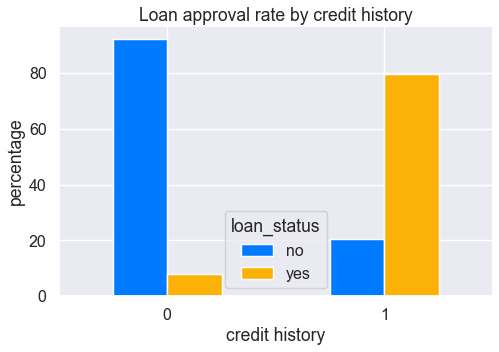

In [19]:
# Let's find the relation between credit history and loan status.
# data preparation
a = df.groupby(by=['credit_history', 'loan_status']).count()['loan_id']* 100 / df.groupby(by=['credit_history']).count()['loan_id']

# plot
a.unstack().plot(kind='bar')

plt.title('Loan approval rate by credit history')
plt.xlabel('credit history')
plt.ylabel('percentage')

plt.xticks(ticks=[0, 1], labels=[0, 1], rotation=0)
plt.legend(labels=['no', 'yes'], title='loan_status')
plt.show()

The above plot shows high rate of loan rejection for applicant with no credit history, and high rate of loan approval for applicant with credit history. We can say that, there is higher chances for loan rejection if an applicant does not have a credit history as compare to the applicant with credit history.

So, we can say that, loan approval is depends on applicant's credit history. Again, we can confirm this finding by computing the chi square hypothesis test.

In [20]:
# Hypothesis test - 'Credit history' vs. 'Loan status'
"""Let's find out if there is any dependency between credit-history and loan approval."""
compute_chi2('credit_history')

Chi2-statistics::  174.63729658142535
p-value::  7.184759548750746e-40
p-value is less than 0.05, the null hypothesis is rejected hence, credit_history & loan_status are dependent variables.


From the above hypothesis test, we can say that loan approval depends on credit history.

#### 2.3.4 Correlation - Education & Loan Status

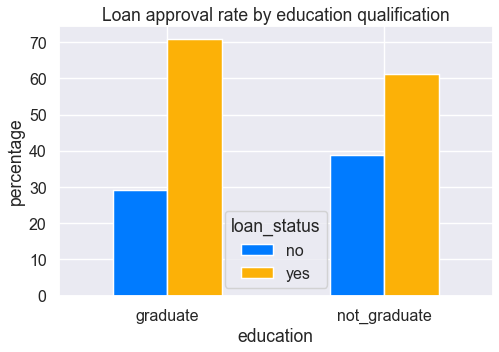

In [21]:
# Let's find the relation between education and loan status.
# data preparation
a = df.groupby(by=['education', 'loan_status']).count()['loan_id']* 100 / df.groupby(by=['education']).count()['loan_id']

# plot
a.unstack().plot(kind='bar')

plt.title('Loan approval rate by education qualification')
plt.xlabel('education')
plt.ylabel('percentage')

plt.xticks(ticks=[0, 1], rotation=0)
plt.legend(labels=['no', 'yes'], title='loan_status')
plt.show()

Above plot shows small difference for rejecting and accepting loan application by education of an applicant. However, The rate of approval for graduate applicant is higher as compare the non-graduate applicant. Let's find out if loan approval depends on education of an applicant by hypothesis test.

In [22]:
# Hypothesis test - 'Education' vs. 'Loan status'
""" Let's find out if there is any effect of educational background on loan approval. """
compute_chi2('education')

Chi2-statistics::  4.091490413303621
p-value::  0.043099621293573545
p-value is less than 0.05, the null hypothesis is rejected hence, education & loan_status are dependent variables.


The above hypothesis test says that, loan approval depends on education of an applicant.

#### 2.3.5 Correlation - Property Area Type & Loan Status

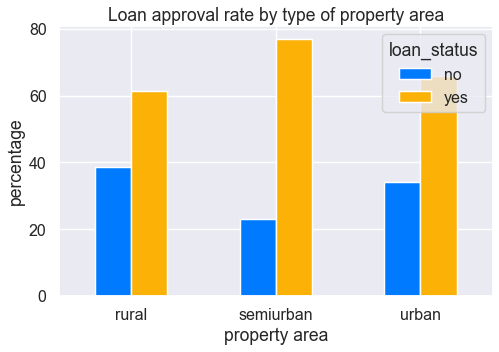

In [23]:
# property_area and loan status
# data preparation
a = df.groupby(by=['property_area', 'loan_status']).count()['loan_id']* 100 / df.groupby(by=['property_area']).count()['loan_id']

# plot
a.unstack().plot(kind='bar')

plt.title('Loan approval rate by type of property area')
plt.xlabel('property area')
plt.ylabel('percentage')

plt.xticks(ticks=[0, 1, 2], rotation=0)
plt.legend(labels=['no', 'yes'], title='loan_status')
plt.show()

We can see that, the home loan approval rate for `semi-urban` property area is higher than other two property areas. 

#### 2.3.6 Correlation - Self Employed & Loan Status

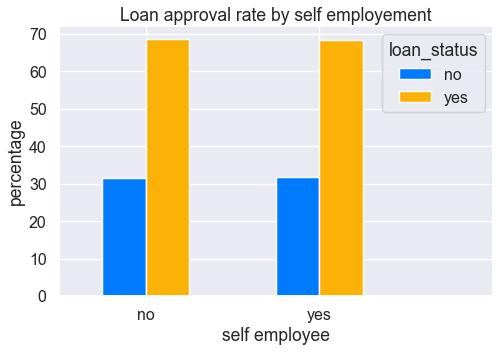

In [24]:
# self_employed and loan status
# data preparation
a = df.groupby(by=['self_employed', 'loan_status']).count()['loan_id']* 100 / df.groupby(by=['self_employed']).count()['loan_id']

# plot
a.unstack().plot(kind='bar')

plt.title('Loan approval rate by self employement')
plt.xlabel('self employee')
plt.ylabel('percentage')

plt.xticks(ticks=[0, 1, 2], rotation=0)
plt.legend(labels=['no', 'yes'], title='loan_status')
plt.show()

There is no such a relation between `self_employed` and `loan_status` variables as percentage of rejection and approval of application is same for employment status of customer.

Let's compute the hypothesis test for all categorical variables.

In [25]:
# Correation between for categorical variables and loan status
scores = []
label = 'loan_status'
for col in categorical_cols:
    threshold = 0.05
    ct = pd.crosstab(df[col], df[label])    
    result = stats.chi2_contingency(ct)
    scores.append((label, col, result[0], round(result[1], 5)))    

In [26]:
corr_df = pd.DataFrame(scores, columns=['target', 'cat_feature', 'chi2_stats', 'p-value'])
corr_df.style.highlight_between(subset=['p-value'], left=-1, right=0.05, color='skyblue')

,target,cat_feature,chi2_stats,p-value
0,loan_status,gender,0.139626,0.708650
1,loan_status,married,4.475019,0.034390
2,loan_status,dependents,3.158340,0.367850
3,loan_status,education,4.091490,0.043100
4,loan_status,self_employed,0.000000,1.000000
5,loan_status,property_area,12.297623,0.002140
6,loan_status,loan_status,609.355922,0.000000


### 2.4 Descriptive Correlation Analysis ( Numerical Variables )

In [27]:
# Descriptive analysis for numerical variable
subsets = ['applicant_income', 'coapplicant_income', 'loan_amount', 'loan_amount_term']
yes_d = round(df.loc[df.loan_status=='y', subsets].describe(), 2)
no_d = round(df.loc[df.loan_status=='n', subsets].describe(), 2)

pd.concat([yes_d, no_d], keys=["Loan status-yes", "Loan status-No"], axis=1)

Loan status-yes                                                  \
      applicant_income coapplicant_income loan_amount loan_amount_term   
count           422.00             422.00      411.00           414.00   
mean           5384.07            1504.52      144.29           341.07   
std            5765.44            1924.75       85.48            63.25   
min             210.00               0.00       17.00            12.00   
25%            2877.50               0.00      100.00           360.00   
50%            3812.50            1239.50      126.00           360.00   
75%            5771.50            2297.25      161.00           360.00   
max           63337.00           20000.00      700.00           480.00   

        Loan status-No                                                  
      applicant_income coapplicant_income loan_amount loan_amount_term  
count           192.00             192.00      181.00           186.00  
mean           5446.08            1877.81      151.22           344.06  
std            6819.56            4384.06       85.86            69.24  
min             150.00               0.00        9.00            36.00  
25%            2885.00               0.00      100.00           360.00  
50%            3833.50             268.00      129.00           360.00  
75%            5861.25            2273.75      176.00           360.00  
max           81000.00           41667.00      570.00           480.00

The above table shows us the descriptive summary for attribute subset by loan status. Applicant and Co-applicant income mean seems to be same for both the status.


Let's further evaluate our findings using one-way ANOVA hypothesis test.

#### 2.4.1 Correlation -  Applicant Income  &  Loan Status

In [28]:
# One way ANOVA hypothesis test.
"""
    Let's compute the one way anova hypothesis test,
    H0: The mean of group of each category of loan status('y', 'n') is same.
    H1: There is difference between these two group means.
"""
f_stats, p_value = stats.f_oneway(df[df.loan_status == 'y']['applicant_income'], 
                                  df[df.loan_status=='n']['applicant_income'])

print("ANOVA hypothesis test::")
print("F_statistics::", f_stats)
print("P-value::", p_value)

ANOVA hypothesis test::
F_statistics:: 0.013574218522301743
P-value:: 0.907287812130378


The above ANOVA test results of loan status has p-value which is greater than 0.05, which fail to reject the null hypothesis. This tells us that there is no statistically significant difference in means of loan status classes.

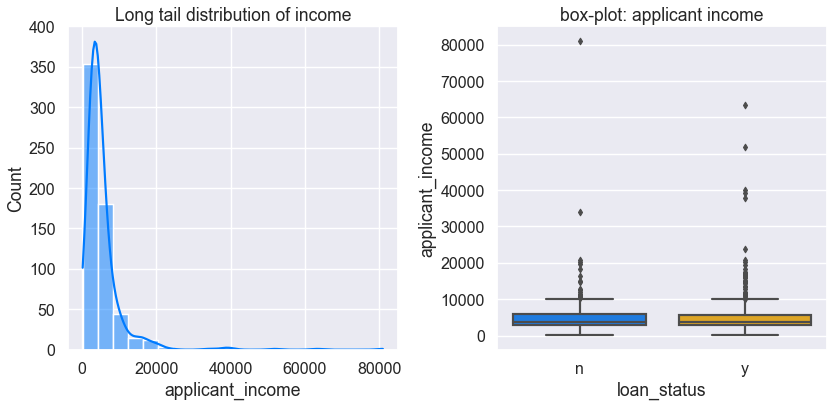

In [29]:
# applicant income
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
plt.subplots_adjust(wspace=0.3)

sns.histplot(data=df, x='applicant_income', bins=20, kde=True, ax=ax1)
ax1.set_title("Long tail distribution of income")

sns.boxplot(data=df, y='applicant_income', x='loan_status', ax=ax2)
ax2.set_title("box-plot: applicant income")
plt.show()

The above plot shows the long tail distribution for applicant income. It seems like there are some outliers present in the data. The above box plot shows, the average income of applicant for both loan status is same. 

#### 2.4.2 Correlation -  Co-applicant Income  &  Loan Status

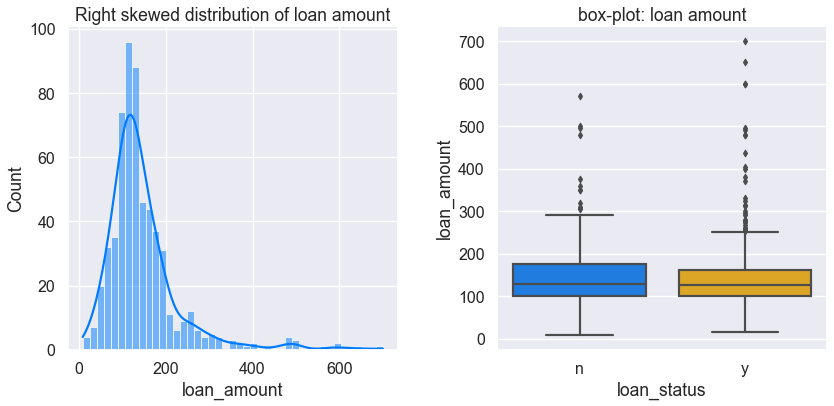

In [30]:
# coapplicant income
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
plt.subplots_adjust(wspace=0.3)

sns.histplot(data=df, x='loan_amount', kde=True, ax=ax1)
ax1.set_title("Right skewed distribution of loan amount")

sns.boxplot(data=df, y='loan_amount', x='loan_status', ax=ax2)
ax2.set_title("box-plot: loan amount")
plt.show()

We can that the there is right skewed distribution of `loan amount` and this box plot also shows that there is no difference between means of loan amount for both classes.

In [31]:
# Statistical description
df[subsets].corr().style.background_gradient(axis=0)

,applicant_income,coapplicant_income,loan_amount,loan_amount_term
applicant_income,1.000000,-0.116605,0.570909,-0.045306
coapplicant_income,-0.116605,1.000000,0.188619,-0.059878
loan_amount,0.570909,0.188619,1.000000,0.039447
loan_amount_term,-0.045306,-0.059878,0.039447,1.000000


The above table shows the correlation between variables, the correlation between loan amount and incomes is high.

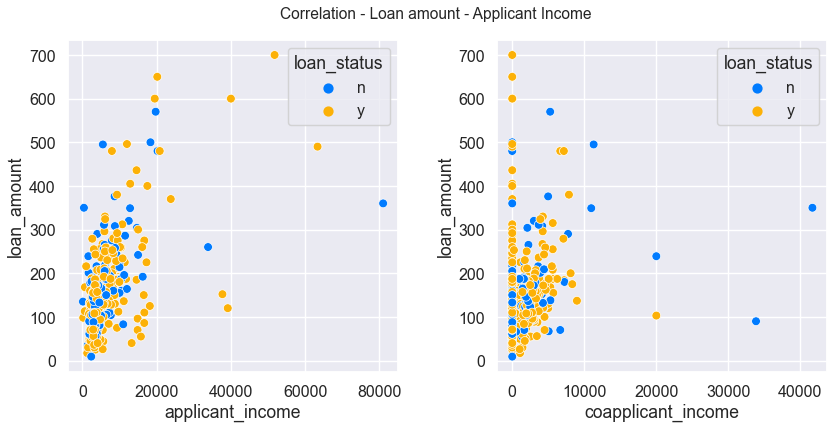

In [32]:
# Let's find out if there is linear relation between these two income variables with loan_amount.
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
plt.subplots_adjust(wspace=0.3, top=0.9)
fig.suptitle("Correlation - Loan amount - Applicant Income", size=16)

sns.scatterplot(data=df, x='applicant_income', y='loan_amount', hue='loan_status', ax=ax1)
sns.scatterplot(data=df, x='coapplicant_income', y='loan_amount', hue='loan_status', ax=ax2)
plt.show()

There is no linear relationship observed in incomes of applicant and amount of loan.

#### 2.4.3 Loan Amount Term

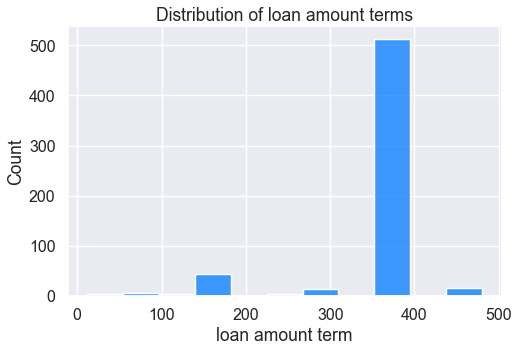

In [33]:
# Distribution of loan_amount_term
sns.histplot(data=df, x='loan_amount_term')
plt.title("Distribution of loan amount terms")
plt.xlabel("loan amount term")
plt.show()

We can see different groups of distribution for `loan_amount_term`

## 3. Data transformation

The distribution of these attributes is not Gaussian. So, let's perform a log transformation to make long tail distribution into normal distribution.
- `applicant_income`
- `coapplicant_income`
- `loan_amount`

In [34]:
# log transformation
df['loan_amount'] = np.log1p(df['loan_amount'])
df['applicant_income'] = np.log1p(df['applicant_income'])
df['coapplicant_income'] = np.log1p(df['coapplicant_income'])

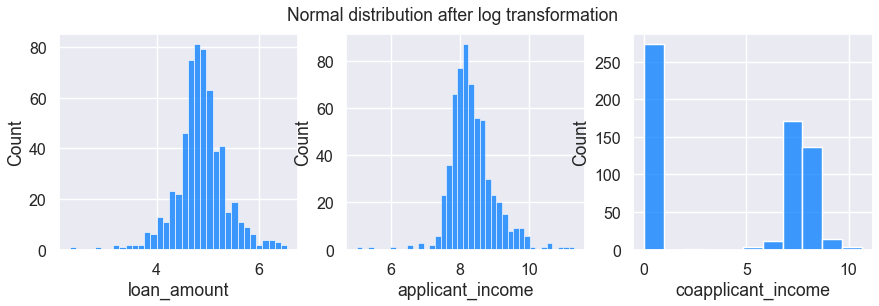

In [35]:
# Plot - Normal distribution after log transformation
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))

fig.suptitle("Normal distribution after log transformation", size=18)

sns.histplot(data=df, x='loan_amount', ax=ax1)
sns.histplot(data=df, x='applicant_income', ax=ax2)
sns.histplot(data=df, x='coapplicant_income', ax=ax3)

plt.show()

### 3.1 Data Pipeline - Numerical & Categorical Preprocessor
There are some outliers and missing values present in the dataset. So, let's clean the data.

In [36]:
# numeric features
numeric_features = ['applicant_income', 'coapplicant_income', 'loan_amount', 'loan_amount_term']
numeric_transformer = Pipeline(
    steps = [
        ("knn_imputer", KNNImputer(n_neighbors=3)), 
        ("scaler", StandardScaler())
    ]
)

# categorical features
categorical_features = ['gender', 'married', 'self_employed', 'dependents', 'credit_history', 'education', 'property_area']
categorical_transformer = Pipeline(
    steps = [
        ("simple_imputer", SimpleImputer(strategy='most_frequent')),
        ("oh_encoder", OneHotEncoder(handle_unknown='ignore'))
    ]
)

# preprocessors
preprocessor = ColumnTransformer(
    transformers = [
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

#### 3.1.1 Split data into training and validation datasets

In [37]:
# split the data into training and validation datasets.
df_full, df_test = train_test_split(df, test_size=0.1, shuffle=True, stratify=df['loan_status'], random_state=42)
df_train, df_valid = train_test_split(df_full, test_size=0.22, shuffle=True, stratify=df_full['loan_status'],random_state=42)

In [38]:
# split the data into X and y
X_train, Y_train = df_train[numeric_features + categorical_features], df_train['loan_status']
X_val, Y_val = df_valid[numeric_features + categorical_features], df_valid['loan_status']

In [39]:
# Data Transformation
x_train = pd.DataFrame(preprocessor.fit_transform(X_train))
y_train = (Y_train == 'y').astype('int').reset_index(drop=True)

x_val = pd.DataFrame(preprocessor.transform(X_val))
y_val = (Y_val == 'y').astype('int').reset_index(drop=True)

## 4. Model Development
### 4.1 Base Model Training

In [73]:
# Base model
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(x_train, y_train)

# prediction
y_preds = model.predict(x_val)

# model evaluation
score = f1_score(y_val, y_preds, average='macro')
print("F1 Score:: %f" % score)

F1 Score:: 0.736748


### 4.2 Spot Checking for Model Training

In [41]:
# spot checking for machine learning algorithms using k-fold==10
models = {
    'rf_clf': RandomForestClassifier(random_state=42),
    'lr_clf': LogisticRegression(max_iter=1000, random_state=42),
    'gb_clf': GradientBoostingClassifier(random_state=42),
    'cart_clf': DecisionTreeClassifier(random_state=42),
    'knn_clf' : KNeighborsClassifier(),
    'svc_clf' : SVC(random_state=42),
    'xgb_clf' : XGBClassifier(random_state=42) 
}

scores = []
for name, clf in models.items():
    CV = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    auc = cross_val_score(clf, x_train, y_train, cv=CV, n_jobs=-1, scoring="f1_macro")
    scores.append((name, np.mean(auc)))

In [42]:
pd.DataFrame(scores, columns=['model', 'f1score']).sort_values(by='f1score', ascending=False).style.highlight_max(subset=['f1score'])

,model,f1score
0,rf_clf,0.717190
5,svc_clf,0.715513
1,lr_clf,0.711163
2,gb_clf,0.706509
6,xgb_clf,0.678063
3,cart_clf,0.671143
4,knn_clf,0.629399


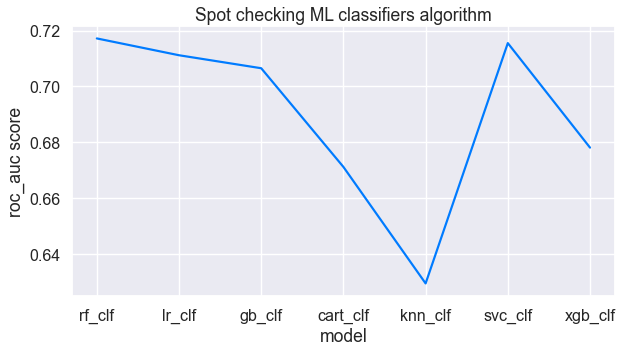

In [43]:
# Data preparation
scores = pd.DataFrame(scores, columns=['model', 'f1score'])

# plots
plt.figure(figsize=(10, 5))
plt.plot(scores.model, scores.f1score)

plt.title("Spot checking ML classifiers algorithm")
plt.xlabel("model")
plt.ylabel("roc_auc score")

plt.show()

`RandomForestClassifier`, `LogisticRegression`, `GradientBoostingClassifier` and `SupportVectorMachine` performs well, let's further evaluate the performance of these classifier by tunning different values for their parameters.

### 4.3 Model development - Gradient Boost Classifier

In [44]:
# Gradient boosting classifier
# let's find the best k values for gradient boosting algorithm
gb_clf = GradientBoostingClassifier(random_state=42)
for k in range(2, 20):
    CV = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    score = cross_val_score(gb_clf, x_train, y_train, cv=CV, n_jobs=-1, scoring="f1_macro")
    print("k=%d; socre=%f" %(k, np.mean(score)))

k=2; socre=0.716992
k=3; socre=0.675221
k=4; socre=0.705438
k=5; socre=0.717545
k=6; socre=0.689805
k=7; socre=0.712561
k=8; socre=0.713602
k=9; socre=0.709629
k=10; socre=0.706509
k=11; socre=0.723153
k=12; socre=0.689545
k=13; socre=0.706890
k=14; socre=0.705796
k=15; socre=0.709426
k=16; socre=0.706236
k=17; socre=0.707426
k=18; socre=0.732977
k=19; socre=0.700041


Gradient boosting classifier gives higher f1 score for k equals to 18, so we will further evaluate the classifier performance using this value.

In [45]:
CV = StratifiedKFold(n_splits=18, shuffle=True, random_state=42)

##### 4.3.1 Hyper-parameter Tunning
**1. parameter - n_estimator**

In [46]:
# n_estimators
for n in range(100, 1000, 100):
    gb_clf = GradientBoostingClassifier(n_estimators=n, random_state=42)
    score = cross_val_score(gb_clf, x_train, y_train, cv=CV, n_jobs=-1, scoring="f1_macro")
    print("n_estimator=%d, socre=%f, std=(+-%.3f)" %(n, np.mean(score), np.std(score)))

n_estimator=100, socre=0.732977, std=(+-0.092)
n_estimator=200, socre=0.702315, std=(+-0.090)
n_estimator=300, socre=0.692328, std=(+-0.088)
n_estimator=400, socre=0.691274, std=(+-0.080)
n_estimator=500, socre=0.681491, std=(+-0.085)
n_estimator=600, socre=0.685670, std=(+-0.084)
n_estimator=700, socre=0.689376, std=(+-0.083)
n_estimator=800, socre=0.689376, std=(+-0.083)
n_estimator=900, socre=0.688757, std=(+-0.077)


**2. parameter - learning_rate**

In [47]:
# learning rate == 250 - 0.04
for n in range(100, 500, 50):
    for alpha in [0.01, 0.02, 0.03]:
        gb_clf = GradientBoostingClassifier(n_estimators=n, learning_rate=alpha, random_state=42)
        score = cross_val_score(gb_clf, x_train, y_train, cv=CV, n_jobs=-1, scoring="f1_macro")
        print("n_estimator=%d, alpha=%f, socre=%f , std=(+-%.3f)" %(n, alpha, np.mean(score),np.std(score)))

n_estimator=100, alpha=0.010000, socre=0.716413 , std=(+-0.079)
n_estimator=100, alpha=0.020000, socre=0.717663 , std=(+-0.093)
n_estimator=100, alpha=0.030000, socre=0.731752 , std=(+-0.092)
n_estimator=150, alpha=0.010000, socre=0.715791 , std=(+-0.086)
n_estimator=150, alpha=0.020000, socre=0.731752 , std=(+-0.092)
n_estimator=150, alpha=0.030000, socre=0.730168 , std=(+-0.094)
n_estimator=200, alpha=0.010000, socre=0.720787 , std=(+-0.097)
n_estimator=200, alpha=0.020000, socre=0.728341 , std=(+-0.094)
n_estimator=200, alpha=0.030000, socre=0.736185 , std=(+-0.089)
n_estimator=250, alpha=0.010000, socre=0.720787 , std=(+-0.097)
n_estimator=250, alpha=0.020000, socre=0.732041 , std=(+-0.087)
n_estimator=250, alpha=0.030000, socre=0.743755 , std=(+-0.089)
n_estimator=300, alpha=0.010000, socre=0.731752 , std=(+-0.092)
n_estimator=300, alpha=0.020000, socre=0.736185 , std=(+-0.089)
n_estimator=300, alpha=0.030000, socre=0.739606 , std=(+-0.091)
n_estimator=350, alpha=0.010000, socre=0

**2. parameter - max_depth**

In [48]:
# max_depth == 3
for depth in [2, 3, 5, 7, 8, 9, 10, 11, 13, 15, 17, 19]:
    gb_clf = GradientBoostingClassifier(n_estimators=250, learning_rate=0.03, max_depth=depth, random_state=42)
    score = cross_val_score(gb_clf, x_train, y_train, cv=CV, n_jobs=-1, scoring="f1_macro")
    print("max-depth=%d, socre=%f, std=(+-%.3f)" %(depth, np.mean(score), np.std(score)))

max-depth=2, socre=0.725581, std=(+-0.085)
max-depth=3, socre=0.743755, std=(+-0.089)
max-depth=5, socre=0.696085, std=(+-0.095)
max-depth=7, socre=0.687195, std=(+-0.093)
max-depth=8, socre=0.689088, std=(+-0.099)
max-depth=9, socre=0.693178, std=(+-0.089)
max-depth=10, socre=0.694200, std=(+-0.084)
max-depth=11, socre=0.680285, std=(+-0.093)
max-depth=13, socre=0.655551, std=(+-0.098)
max-depth=15, socre=0.666783, std=(+-0.098)
max-depth=17, socre=0.669713, std=(+-0.100)
max-depth=19, socre=0.659764, std=(+-0.101)


**3. parameter -  min_samples_split**

In [49]:
# min_samples_split = 200
for samples in [50, 100, 200, 300, 400]:
    gb_clf = GradientBoostingClassifier(n_estimators=250, learning_rate=0.03, max_depth=3, min_samples_split=samples, random_state=42)
    score = cross_val_score(gb_clf, x_train, y_train, cv=CV, n_jobs=-1, scoring="f1_macro")
    print("min-samples=%d, socre=%f, std=(+-%.3f)" %(samples, np.mean(score), np.std(score)))

min-samples=50, socre=0.734087, std=(+-0.084)
min-samples=100, socre=0.729451, std=(+-0.078)
min-samples=200, socre=0.736340, std=(+-0.081)
min-samples=300, socre=0.721427, std=(+-0.094)
min-samples=400, socre=0.719346, std=(+-0.090)


**4. parameter - min_samples_leaf**

In [50]:
# min_samples_leaf == 50
for samples in [10, 30, 50, 70, 100]:
    gb_clf = GradientBoostingClassifier(n_estimators=250, learning_rate=0.03, max_depth=3, min_samples_split=200, min_samples_leaf=samples, random_state=42)
    score = cross_val_score(gb_clf, x_train, y_train, cv=CV, n_jobs=-1, scoring="f1_macro")
    print("min-samples-leaf=%d, socre=%f, std=(+-%.3f)" %(samples, np.mean(score), np.std(score)))

min-samples-leaf=10, socre=0.723544, std=(+-0.077)
min-samples-leaf=30, socre=0.717595, std=(+-0.076)
min-samples-leaf=50, socre=0.725506, std=(+-0.097)
min-samples-leaf=70, socre=0.436216, std=(+-0.079)
min-samples-leaf=100, socre=0.427647, std=(+-0.055)


**5. parameter - max_features**

In [51]:
# max_features == 11
for features in range(5, 22, 2):
    gb_clf = GradientBoostingClassifier(n_estimators=250, 
                                        learning_rate=0.03, 
                                        max_depth=3, 
                                        min_samples_split=200, 
                                        min_samples_leaf=50,
                                        max_features=features,
                                        random_state=42)
    score = cross_val_score(gb_clf, x_train, y_train, cv=CV, n_jobs=-1, scoring="f1_macro")
    print("min-features=%d, socre=%f, std=(+-%.3f)" %(features, np.mean(score), np.std(score)))
    

min-features=5, socre=0.722482, std=(+-0.080)
min-features=7, socre=0.715930, std=(+-0.086)
min-features=9, socre=0.718609, std=(+-0.085)
min-features=11, socre=0.725506, std=(+-0.097)
min-features=13, socre=0.725506, std=(+-0.097)
min-features=15, socre=0.725506, std=(+-0.097)
min-features=17, socre=0.725506, std=(+-0.097)
min-features=19, socre=0.727500, std=(+-0.095)
min-features=21, socre=0.725506, std=(+-0.097)


**Final Model Gradient boosting classifier**

In [52]:
gb_clf = GradientBoostingClassifier(n_estimators=250, 
                                    learning_rate=0.03, 
                                    max_depth=3, 
                                    min_samples_split=200, 
                                    min_samples_leaf=50,
                                    max_features=11,
                                    warm_start=True,
                                    random_state=42
                                   )

gb_clf.fit(x_train, y_train)
y_preds = gb_clf.predict(x_val)
score = f1_score(y_val, y_preds, average='macro')
print("f-score::%f" %score)

f-score::0.778986


#### 4.4 Model development - Support Vector Machine Classifier

##### 4.4.1 Best K-fold for SVC

In [53]:
# Support Vector machine classifier
# let's find the best k values for further evaluation
svc_clf = SVC(random_state=42)
for k in range(2, 20):
    CV = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    score = cross_val_score(svc_clf, x_train, y_train, cv=CV, n_jobs=-1, scoring="f1_macro")
    print("k=%d; socre=%f" %(k, np.mean(score)))

k=2; socre=0.701845
k=3; socre=0.721855
k=4; socre=0.716689
k=5; socre=0.721990
k=6; socre=0.714814
k=7; socre=0.716655
k=8; socre=0.718014
k=9; socre=0.718799
k=10; socre=0.715513
k=11; socre=0.713915
k=12; socre=0.716468
k=13; socre=0.710981
k=14; socre=0.709537
k=15; socre=0.708144
k=16; socre=0.712611
k=17; socre=0.705664
k=18; socre=0.716343
k=19; socre=0.709951


In [54]:
CV = StratifiedKFold(n_splits=8, shuffle=True, random_state=42)

##### 4.4.2 Hyper-parameter Tunning
**1. parameter - C**

In [55]:
# C == 3
for c in [1, 3, 5, 7, 9, 11, 15, 20, 30, 50, 100]:
    svc_clf = SVC(C=c, random_state=42)
    score = cross_val_score(svc_clf, x_train, y_train, cv=CV, n_jobs=-1, scoring="f1_macro")
    print("C=%d; socre=%f, std=%.3f" %(c, np.mean(score), np.std(score)))

C=1; socre=0.718014, std=0.065
C=3; socre=0.727124, std=0.066
C=5; socre=0.712077, std=0.050
C=7; socre=0.699171, std=0.050
C=9; socre=0.684538, std=0.045
C=11; socre=0.674379, std=0.050
C=15; socre=0.661965, std=0.051
C=20; socre=0.637812, std=0.052
C=30; socre=0.633902, std=0.052
C=50; socre=0.639668, std=0.049
C=100; socre=0.639681, std=0.052


**2. parameter - gamma**

In [56]:
# gamma == 0.1
for g in [1, 0.1, 0.01, 0.001]:
    svc_clf = SVC(C=3, gamma=g, random_state=42)
    score = cross_val_score(svc_clf, x_train, y_train, cv=CV, n_jobs=-1, scoring="f1_macro")
    print("gamma=%f; socre=%f, std=%.3f" %(g, np.mean(score), np.std(score)))

gamma=1.000000; socre=0.563662, std=0.045
gamma=0.100000; socre=0.732151, std=0.071
gamma=0.010000; socre=0.721004, std=0.065
gamma=0.001000; socre=0.406896, std=0.002


**3. parameter - degree**

In [57]:
# degree == 2
for d in [1, 2, 3, 4, 5, 6, 7, 9, 10]:
    svc_clf = SVC(C=3, kernel='poly', gamma=0.1, degree=d, random_state=42)
    score = cross_val_score(svc_clf, x_train, y_train, cv=CV, n_jobs=-1, scoring="f1_macro")
    print("degree=%d; socre=%f, std=%.3f" %(d, np.mean(score), np.std(score)))

degree=1; socre=0.721004, std=0.065
degree=2; socre=0.713049, std=0.070
degree=3; socre=0.724677, std=0.058
degree=4; socre=0.698645, std=0.051
degree=5; socre=0.694915, std=0.062
degree=6; socre=0.669665, std=0.057
degree=7; socre=0.669638, std=0.056
degree=9; socre=0.628756, std=0.034
degree=10; socre=0.601948, std=0.054


**4. parameter - kernel**

In [58]:
# kernel == 2
for kr in ['linear', 'poly', 'rbf', 'sigmoid'] :
    svc_clf = SVC(C=3, kernel=kr, gamma=0.1, random_state=42)
    score = cross_val_score(svc_clf, x_train, y_train, cv=CV, n_jobs=-1, scoring="f1_macro")
    print("kernel=%s; socre=%f, std=%.3f" %(kr, np.mean(score), np.std(score)))

kernel=linear; socre=0.721004, std=0.065
kernel=poly; socre=0.724677, std=0.058
kernel=rbf; socre=0.732151, std=0.071
kernel=sigmoid; socre=0.669926, std=0.060


**Final Model SVC**

In [59]:
# final model 
svc = SVC(C=3, gamma=0.1, random_state=42)
svc.fit(x_train, y_train)
y_preds = svc.predict(x_val)
print("score::%f" %f1_score(y_val, y_preds, average='macro'))

score::0.726776


#### 4.5 Model development - Random Forest Classifier

##### 4.5.1 Best K-fold for SVC

In [60]:
# RandomForestClassifier k = 15
RF_clf = RandomForestClassifier(random_state=42)
for k in range(2, 20):
    CV = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    score = cross_val_score(RF_clf, x_train, y_train, cv=CV, n_jobs=-1, scoring="f1_macro")
    print("K-fold=%d, socre=%f, std=%.3f" %(k, np.mean(score), np.std(score)))

K-fold=2, socre=0.706562, std=0.022
K-fold=3, socre=0.701173, std=0.048
K-fold=4, socre=0.715985, std=0.024
K-fold=5, socre=0.708743, std=0.069
K-fold=6, socre=0.708265, std=0.051
K-fold=7, socre=0.716652, std=0.055
K-fold=8, socre=0.719051, std=0.050
K-fold=9, socre=0.705722, std=0.056
K-fold=10, socre=0.717190, std=0.075
K-fold=11, socre=0.719744, std=0.072
K-fold=12, socre=0.716996, std=0.075
K-fold=13, socre=0.717239, std=0.080
K-fold=14, socre=0.718409, std=0.074
K-fold=15, socre=0.723055, std=0.080
K-fold=16, socre=0.717702, std=0.084
K-fold=17, socre=0.717298, std=0.114
K-fold=18, socre=0.712053, std=0.098
K-fold=19, socre=0.717887, std=0.113


In [61]:
CV = StratifiedKFold(n_splits=15, shuffle=True, random_state=42)

##### 4.5.2 Hyper-parameter Tunning
**1. parameter - n_estimators**

In [62]:
# n_estimators == 250
for n in range(200, 400, 50):
    RF_clf = RandomForestClassifier(n_estimators=n, random_state=42)
    score = cross_val_score(RF_clf, x_train, y_train, cv=CV, n_jobs=-1, scoring="f1_macro")
    print("n_estimator=%d, socre=%f, std=%.3f" %(n, np.mean(score), np.std(score)))

n_estimator=200, socre=0.724482, std=0.085
n_estimator=250, socre=0.729259, std=0.085
n_estimator=300, socre=0.722765, std=0.091
n_estimator=350, socre=0.717182, std=0.094


**2. parameter - n_estimators & max_depth**

In [63]:
# max_depth == 15 for n_estimator=110
for n in range(10, 500, 50):
    for depth in [5, 7, 9, 8, 10, 11, 12, 13, 15]:
        RF_clf = RandomForestClassifier(n_estimators=n, max_depth=depth, random_state=42)
        score = cross_val_score(RF_clf, x_train, y_train, cv=CV, n_jobs=-1, scoring="f1_macro")
        print("n_estimator=%d, depth=%d, socre=%f, std=%.3f" %(n, depth, np.mean(score), np.std(score)))

n_estimator=10, depth=5, socre=0.712612, std=0.097
n_estimator=10, depth=7, socre=0.711606, std=0.075
n_estimator=10, depth=9, socre=0.734496, std=0.088
n_estimator=10, depth=8, socre=0.720620, std=0.096
n_estimator=10, depth=10, socre=0.710200, std=0.078
n_estimator=10, depth=11, socre=0.724541, std=0.082
n_estimator=10, depth=12, socre=0.718467, std=0.085
n_estimator=10, depth=13, socre=0.703423, std=0.085
n_estimator=10, depth=15, socre=0.721050, std=0.085
n_estimator=60, depth=5, socre=0.719063, std=0.085
n_estimator=60, depth=7, socre=0.721753, std=0.086
n_estimator=60, depth=9, socre=0.733138, std=0.095
n_estimator=60, depth=8, socre=0.723997, std=0.095
n_estimator=60, depth=10, socre=0.732262, std=0.085
n_estimator=60, depth=11, socre=0.720391, std=0.088
n_estimator=60, depth=12, socre=0.725717, std=0.092
n_estimator=60, depth=13, socre=0.717216, std=0.080
n_estimator=60, depth=15, socre=0.723070, std=0.088
n_estimator=110, depth=5, socre=0.716341, std=0.089
n_estimator=110, dep

**3. parameter - min_samples_split**

In [64]:
# min_samples_split == 3
for samples in [3, 6, 7, 8, 9, 10, 50]:
    RF_clf = RandomForestClassifier(n_estimators=110, max_depth=15, min_samples_split=samples, random_state=42)
    score = cross_val_score(RF_clf, x_train, y_train, cv=CV, n_jobs=-1, scoring="f1_macro")
    print("min-samples=%d, socre=%f, std=(+-%.3f)" %(samples, np.mean(score), np.std(score)))

min-samples=3, socre=0.736309, std=(+-0.090)
min-samples=6, socre=0.733674, std=(+-0.083)
min-samples=7, socre=0.729986, std=(+-0.084)
min-samples=8, socre=0.733319, std=(+-0.075)
min-samples=9, socre=0.730030, std=(+-0.077)
min-samples=10, socre=0.733704, std=(+-0.088)
min-samples=50, socre=0.716341, std=(+-0.089)


**4. parameter - max_features**

In [65]:
# max_features == 'sqrt'
for features in list(range(1, 22, 2))+['sqrt', 'log2']:
    RF_clf = RandomForestClassifier(n_estimators=110, 
                                    max_depth=15, 
                                    min_samples_split=3,
                                    min_samples_leaf=1,
                                    max_features=features,
                                    warm_start=True,
                                    random_state=42)
    score = cross_val_score(RF_clf, x_train, y_train, cv=CV, n_jobs=-1, scoring="f1_macro")
    print("max-features=%s, socre=%f, std=(+-%.3f)" %(features, np.mean(score), np.std(score)))

max-features=1, socre=0.705393, std=(+-0.093)
max-features=3, socre=0.715442, std=(+-0.080)
max-features=5, socre=0.730218, std=(+-0.085)
max-features=7, socre=0.713781, std=(+-0.078)
max-features=9, socre=0.716620, std=(+-0.081)
max-features=11, socre=0.724054, std=(+-0.088)
max-features=13, socre=0.723633, std=(+-0.081)
max-features=15, socre=0.725086, std=(+-0.078)
max-features=17, socre=0.719031, std=(+-0.078)
max-features=19, socre=0.732536, std=(+-0.069)
max-features=21, socre=0.719233, std=(+-0.080)
max-features=sqrt, socre=0.736309, std=(+-0.090)
max-features=log2, socre=0.736309, std=(+-0.090)


**Final Model - Random forest classifier**

In [66]:
# final model 
RF_clf = RandomForestClassifier(n_estimators=110, 
                                max_depth=15, 
                                min_samples_split=3,
                                min_samples_leaf=1,
                                max_features='sqrt',
                                n_jobs=-1,
                                random_state=42)
RF_clf.fit(x_train, y_train)
y_preds = RF_clf.predict(x_val)
print("score::%f" %f1_score(y_val, y_preds, average='macro'))

score::0.740518


#### 4.6 Model development - Logistic Regression

##### 4.6.1 Hyper-parameter Tunning

**Parameter - C**

In [67]:
# C = 0.1
for c in [0.1, 0.2, 0.3, 0.5, 0.8, 1, 1.2]:
    LR_clf = LogisticRegression(solver='liblinear', C=c, random_state=42)
    LR_clf.fit(x_train, y_train)
    y_preds = LR_clf.predict(x_val)
    print("C::%f score::%f" % (c, f1_score(y_val, y_preds, average='macro')))

C::0.100000 score::0.745061
C::0.200000 score::0.736748
C::0.300000 score::0.736748
C::0.500000 score::0.736748
C::0.800000 score::0.736748
C::1.000000 score::0.736748
C::1.200000 score::0.736748


## 5. Final Models Evaluation

In [68]:
# models 
GB_clf = GradientBoostingClassifier(n_estimators=250, 
                                    learning_rate=0.03, 
                                    max_depth=3, 
                                    min_samples_split=200, 
                                    min_samples_leaf=50,
                                    max_features=11,
                                    warm_start=True,
                                    random_state=42
                                   )
RF_clf = RandomForestClassifier(n_estimators=110, 
                                max_depth=15, 
                                min_samples_split=3,
                                min_samples_leaf=1,
                                max_features='sqrt',
                                n_jobs=-1,
                                random_state=42)
SVC_clf = SVC(C=3, gamma=0.1, random_state=42)
LR_clf = LogisticRegression(solver='liblinear', C=0.1, random_state=42)

for model in [GB_clf, RF_clf, SVC_clf, LR_clf]:
    model.fit(x_train, y_train)
    y_preds = model.predict(x_val)
    score = f1_score(y_val, y_preds, average='macro')
    print("Classifier:: %s" % model)
    print("F1-Score::%f" % score)    

Classifier:: GradientBoostingClassifier(learning_rate=0.03, max_features=11,
                           min_samples_leaf=50, min_samples_split=200,
                           n_estimators=250, random_state=42, warm_start=True)
F1-Score::0.778986
Classifier:: RandomForestClassifier(max_depth=15, min_samples_split=3, n_estimators=110,
                       n_jobs=-1, random_state=42)
F1-Score::0.740518
Classifier:: SVC(C=3, gamma=0.1, random_state=42)
F1-Score::0.726776
Classifier:: LogisticRegression(C=0.1, random_state=42, solver='liblinear')
F1-Score::0.745061


### 5.1 Model Evaluation on Test Dataset

In [69]:
# Data preparation
X_test, Y_test = df_test[numeric_features + categorical_features], df_test['loan_status']
x_test = pd.DataFrame(preprocessor.transform(X_test))
y_test = (Y_test == 'y').astype('int').reset_index(drop=True)

In [70]:
# Model evaluation on test dataset
for model in [GB_clf, RF_clf, SVC_clf, LR_clf]:
    y_preds = model.predict(x_test)
    score = f1_score(y_test, y_preds, average='macro')
    print("Classifier:: %s" % model)
    print("F1-Score::%f" % score)    

Classifier:: GradientBoostingClassifier(learning_rate=0.03, max_features=11,
                           min_samples_leaf=50, min_samples_split=200,
                           n_estimators=250, random_state=42, warm_start=True)
F1-Score::0.780142
Classifier:: RandomForestClassifier(max_depth=15, min_samples_split=3, n_estimators=110,
                       n_jobs=-1, random_state=42)
F1-Score::0.720430
Classifier:: SVC(C=3, gamma=0.1, random_state=42)
F1-Score::0.763441
Classifier:: LogisticRegression(C=0.1, random_state=42, solver='liblinear')
F1-Score::0.752450


`GradientBoostingClassifier` gives higher f1 score on test data. Hence, it is selected as a final model